# A guide Portfolio Optimization Environment

This notebook aims to provide an example of using PortfolioOptimizationEnv (or POE) to train a reinforcement learning model that learns to solve the portfolio optimization problem.

In this document, we will reproduce a famous architecture called EIIE (ensemble of identical independent evaluators), introduced in the following paper:

- Zhengyao Jiang, Dixing Xu, & Jinjun Liang. (2017). A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem. https://doi.org/10.48550/arXiv.1706.10059.

It's advisable to read it to understand the algorithm implemented in this notebook.

### Note
If you're using this environment, consider citing the following paper (in adittion to FinRL references):

- Caio Costa, & Anna Costa (2023). POE: A General Portfolio Optimization Environment for FinRL. In *Anais do II Brazilian Workshop on Artificial Intelligence in Finance* (pp. 132–143). SBC. https://doi.org/10.5753/bwaif.2023.231144.

```
@inproceedings{bwaif,
 author = {Caio Costa and Anna Costa},
 title = {POE: A General Portfolio Optimization Environment for FinRL},
 booktitle = {Anais do II Brazilian Workshop on Artificial Intelligence in Finance},
 location = {João Pessoa/PB},
 year = {2023},
 keywords = {},
 issn = {0000-0000},
 pages = {132--143},
 publisher = {SBC},
 address = {Porto Alegre, RS, Brasil},
 doi = {10.5753/bwaif.2023.231144},
 url = {https://sol.sbc.org.br/index.php/bwaif/article/view/24959}
}

```

## Installation and imports

To run this notebook in google colab, uncomment the cells below.

In [13]:
## install finrl library
# !sudo apt install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [14]:
## We also need to install quantstats, because the environment uses it to plot graphs
# !pip install quantstats

In [15]:
## Hide matplotlib warnings
# import warnings
# warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

#### Import the necessary code libraries

In [16]:
import torch

import numpy as np

from sklearn.preprocessing import MaxAbsScaler

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Fetch data

In his paper, *Jiang et al* creates a portfolio composed by the top-11 cryptocurrencies based on 30-days volume. Since it's not specified when this classification was done, it's difficult to reproduce, so we will use a similar approach in the Brazillian stock market:

- We select top-10 stocks from Brazillian stock market;
- For simplicity, we disconsider stocks that have missing data for the days in period 2011-01-01 to 2019-12-31 (9 years);

In [17]:
TOP_BRL = [
    "VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "RENT3.SA", "LREN3.SA", "PRIO3.SA",
    "WEGE3.SA", "ABEV3.SA"
]

In [18]:
print(len(TOP_BRL))

portfolio_raw_df = YahooDownloader(start_date = '2011-01-01',
                                end_date = '2022-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_raw_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

10



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (29780, 8)


,date,open,high,low,close,volume,tic,day
0,2011-01-03,8.632311,8.728203,8.630313,5.265025,576145,ABEV3.SA,0
1,2011-01-03,15.750000,15.900000,15.690000,6.314927,6626800,BBAS3.SA,0
2,2011-01-03,11.809763,11.927362,11.724237,6.245440,10862336,BBDC4.SA,0
3,2011-01-03,18.031555,18.250118,17.963253,10.571315,10014663,ITUB4.SA,0
4,2011-01-03,8.422694,8.629907,8.422694,6.107300,3652542,LREN3.SA,0
...,...,...,...,...,...,...,...,...
29775,2022-12-29,24.990000,25.049999,24.430000,16.668446,57901800,PETR4.SA,3
29776,2022-12-29,37.250000,37.480000,36.619999,37.150330,7890300,PRIO3.SA,3
29777,2022-12-29,54.300869,55.776001,52.626392,50.361671,8786791,RENT3.SA,3
29778,2022-12-29,89.000000,89.949997,88.830002,77.194092,40110800,VALE3.SA,3


In [19]:
portfolio_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,2978,2978,2978,2978,2978,2978,2978
BBAS3.SA,2978,2978,2978,2978,2978,2978,2978
BBDC4.SA,2978,2978,2978,2978,2978,2978,2978
ITUB4.SA,2978,2978,2978,2978,2978,2978,2978
LREN3.SA,2978,2978,2978,2978,2978,2978,2978
PETR4.SA,2978,2978,2978,2978,2978,2978,2978
PRIO3.SA,2978,2978,2978,2978,2978,2978,2978
RENT3.SA,2978,2978,2978,2978,2978,2978,2978
VALE3.SA,2978,2978,2978,2978,2978,2978,2978


### Normalize Data

We normalize the data dividing the time series of each stock by its maximum value, so that the dataframe contains values between 0 and 1.

In [20]:
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(portfolio_raw_df)
portfolio_norm_df

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.00200262 0.00114137 0.0010422  ... 0.04565734 0.05214546 0.07760399]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.   0.25 0.5  ... 0.25 0.5  0.75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(


,date,open,high,low,close,volume,tic,day
0,2011-01-03,0.353928,0.355383,0.359147,0.272027,0.002003,ABEV3.SA,0.00
1,2011-01-03,0.566547,0.568771,0.572419,0.320274,0.014581,BBAS3.SA,0.00
2,2011-01-03,0.396939,0.397479,0.399922,0.284189,0.021760,BBDC4.SA,0.00
3,2011-01-03,0.466293,0.458661,0.467793,0.341453,0.062331,ITUB4.SA,0.00
4,2011-01-03,0.153498,0.157120,0.155466,0.126038,0.072591,LREN3.SA,0.00
...,...,...,...,...,...,...,...,...
29775,2022-12-29,0.663745,0.652514,0.662958,0.694899,0.082841,PETR4.SA,0.75
29776,2022-12-29,0.858295,0.844144,0.878173,0.857373,0.048724,PRIO3.SA,0.75
29777,2022-12-29,0.737949,0.754746,0.727218,0.728877,0.097191,RENT3.SA,0.75
29778,2022-12-29,0.742905,0.746783,0.770759,0.916710,0.218546,VALE3.SA,0.75


In [21]:
df_portfolio = portfolio_norm_df[["date", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[(df_portfolio["date"] >= "2011-01-01") & (df_portfolio["date"] < "2019-12-31")]
df_portfolio_2020 = df_portfolio[(df_portfolio["date"] >= "2020-01-01") & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]

### Instantiate Environment

Using the `PortfolioOptimizationEnv`, it's easy to instantiate a portfolio optimization environment for reinforcement learning agents. In the example below, we use the dataframe created before to start an environment.

In [22]:
environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        normalize_df=None
    )

### Instantiate Model

Now, we can instantiate the model using FinRL API. In this example, we are going to use the EIIE architecture introduced by Jiang et. al.

:exclamation: **Note:** Remember to set the architecture's `time_window` parameter with the same value of the environment's `time_window`.

In [23]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": 50,
}

model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

### Train Model

In [24]:
DRLAgent.train_model(model, episodes=40)

  0%|          | 0/40 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 349978.59375
Final accumulative portfolio value: 3.4997859375
Maximum DrawDown: -0.4352402605019139
Sharpe ratio: 0.7843811476016066


  2%|▎         | 1/40 [00:28<18:38, 28.67s/it]

Initial portfolio value:100000
Final portfolio value: 465155.4375
Final accumulative portfolio value: 4.651554375
Maximum DrawDown: -0.46065935484174536
Sharpe ratio: 0.9312217906766693


  5%|▌         | 2/40 [00:56<18:00, 28.42s/it]

Initial portfolio value:100000
Final portfolio value: 597771.375
Final accumulative portfolio value: 5.97771375
Maximum DrawDown: -0.5406583049427491
Sharpe ratio: 0.9857889624862904


  8%|▊         | 3/40 [01:23<16:52, 27.37s/it]

Initial portfolio value:100000
Final portfolio value: 714834.75
Final accumulative portfolio value: 7.1483475
Maximum DrawDown: -0.5214058553503111
Sharpe ratio: 1.0663150977033644


 10%|█         | 4/40 [01:47<15:48, 26.36s/it]

Initial portfolio value:100000
Final portfolio value: 862521.25
Final accumulative portfolio value: 8.6252125
Maximum DrawDown: -0.5446905076620979
Sharpe ratio: 1.0620290893588311


 12%|█▎        | 5/40 [02:14<15:22, 26.35s/it]

Initial portfolio value:100000
Final portfolio value: 815291.0
Final accumulative portfolio value: 8.15291
Maximum DrawDown: -0.6777367614141845
Sharpe ratio: 0.90431870891676


 15%|█▌        | 6/40 [02:40<14:56, 26.36s/it]

Initial portfolio value:100000
Final portfolio value: 1003125.25
Final accumulative portfolio value: 10.0312525
Maximum DrawDown: -0.6257424553761448
Sharpe ratio: 1.0178898286077311


 18%|█▊        | 7/40 [03:06<14:26, 26.25s/it]

Initial portfolio value:100000
Final portfolio value: 1102527.625
Final accumulative portfolio value: 11.02527625
Maximum DrawDown: -0.6364022216457476
Sharpe ratio: 1.0207633434806938


 20%|██        | 8/40 [03:31<13:44, 25.77s/it]

Initial portfolio value:100000
Final portfolio value: 1271056.25
Final accumulative portfolio value: 12.7105625
Maximum DrawDown: -0.6277897706711147
Sharpe ratio: 1.0464727315585085


 22%|██▎       | 9/40 [03:55<13:05, 25.33s/it]

Initial portfolio value:100000
Final portfolio value: 1308119.5
Final accumulative portfolio value: 13.081195
Maximum DrawDown: -0.6594922846899753
Sharpe ratio: 1.0177208890345466


 25%|██▌       | 10/40 [04:20<12:31, 25.06s/it]

Initial portfolio value:100000
Final portfolio value: 1472087.5
Final accumulative portfolio value: 14.720875
Maximum DrawDown: -0.6410025058826376
Sharpe ratio: 1.044978976333894


 28%|██▊       | 11/40 [04:45<12:06, 25.04s/it]

Initial portfolio value:100000
Final portfolio value: 1493068.375
Final accumulative portfolio value: 14.93068375
Maximum DrawDown: -0.654508229495708
Sharpe ratio: 1.0361995950982277


 30%|███       | 12/40 [05:14<12:20, 26.46s/it]

Initial portfolio value:100000
Final portfolio value: 1601045.75
Final accumulative portfolio value: 16.0104575
Maximum DrawDown: -0.6474480981380515
Sharpe ratio: 1.0420908726729732


 32%|███▎      | 13/40 [05:43<12:15, 27.25s/it]

Initial portfolio value:100000
Final portfolio value: 1667770.125
Final accumulative portfolio value: 16.67770125
Maximum DrawDown: -0.6455532417237138
Sharpe ratio: 1.0437387189469987


 35%|███▌      | 14/40 [06:11<11:53, 27.45s/it]

Initial portfolio value:100000
Final portfolio value: 1716898.75
Final accumulative portfolio value: 17.1689875
Maximum DrawDown: -0.6468928110352837
Sharpe ratio: 1.054968386284607


 38%|███▊      | 15/40 [06:40<11:33, 27.73s/it]

Initial portfolio value:100000
Final portfolio value: 1786959.75
Final accumulative portfolio value: 17.8695975
Maximum DrawDown: -0.635897880904553
Sharpe ratio: 1.0615193344396852


 40%|████      | 16/40 [07:05<10:46, 26.94s/it]

Initial portfolio value:100000
Final portfolio value: 1731820.875
Final accumulative portfolio value: 17.31820875
Maximum DrawDown: -0.6613473848509013
Sharpe ratio: 1.059154460869015


 42%|████▎     | 17/40 [07:33<10:28, 27.32s/it]

Initial portfolio value:100000
Final portfolio value: 1845720.0
Final accumulative portfolio value: 18.4572
Maximum DrawDown: -0.6092820796700668
Sharpe ratio: 1.0702424701606872


 45%|████▌     | 18/40 [08:01<10:08, 27.67s/it]

Initial portfolio value:100000
Final portfolio value: 1871151.5
Final accumulative portfolio value: 18.711515
Maximum DrawDown: -0.6385415411657849
Sharpe ratio: 1.0556768868998594


 48%|████▊     | 19/40 [08:30<09:46, 27.95s/it]

Initial portfolio value:100000
Final portfolio value: 1816096.25
Final accumulative portfolio value: 18.1609625
Maximum DrawDown: -0.665796879832464
Sharpe ratio: 1.0483064315981863


 50%|█████     | 20/40 [08:57<09:12, 27.62s/it]

Initial portfolio value:100000
Final portfolio value: 1848458.125
Final accumulative portfolio value: 18.48458125
Maximum DrawDown: -0.6002597272984433
Sharpe ratio: 1.0496104426659678


 52%|█████▎    | 21/40 [09:24<08:41, 27.46s/it]

Initial portfolio value:100000
Final portfolio value: 1371323.75
Final accumulative portfolio value: 13.7132375
Maximum DrawDown: -0.8458700224858671
Sharpe ratio: 0.7893997070010964


 55%|█████▌    | 22/40 [09:51<08:11, 27.30s/it]

Initial portfolio value:100000
Final portfolio value: 1560950.5
Final accumulative portfolio value: 15.609505
Maximum DrawDown: -0.8126397530908205
Sharpe ratio: 0.8431808454945504


 57%|█████▊    | 23/40 [10:17<07:38, 26.95s/it]

Initial portfolio value:100000
Final portfolio value: 1334424.375
Final accumulative portfolio value: 13.34424375
Maximum DrawDown: -0.8408031970098075
Sharpe ratio: 0.7790576902234737


 60%|██████    | 24/40 [10:45<07:14, 27.16s/it]

Initial portfolio value:100000
Final portfolio value: 1680328.0
Final accumulative portfolio value: 16.80328
Maximum DrawDown: -0.8052766375588015
Sharpe ratio: 0.871081968180035


 62%|██████▎   | 25/40 [11:18<07:12, 28.86s/it]

Initial portfolio value:100000
Final portfolio value: 710570.875
Final accumulative portfolio value: 7.10570875
Maximum DrawDown: -0.862369320139756
Sharpe ratio: 0.6570919624643332


 65%|██████▌   | 26/40 [11:44<06:35, 28.27s/it]

Initial portfolio value:100000
Final portfolio value: 1362104.25
Final accumulative portfolio value: 13.6210425
Maximum DrawDown: -0.8328862122126632
Sharpe ratio: 0.8185304545968548


 68%|██████▊   | 27/40 [12:10<05:55, 27.31s/it]

Initial portfolio value:100000
Final portfolio value: 1359548.5
Final accumulative portfolio value: 13.595485
Maximum DrawDown: -0.8587723836150898
Sharpe ratio: 0.7820035977707819


 70%|███████   | 28/40 [12:41<05:40, 28.41s/it]

Initial portfolio value:100000
Final portfolio value: 1466354.5
Final accumulative portfolio value: 14.663545
Maximum DrawDown: -0.8113646666722291
Sharpe ratio: 0.8405433861246943


 72%|███████▎  | 29/40 [13:11<05:20, 29.11s/it]

Initial portfolio value:100000
Final portfolio value: 1837136.875
Final accumulative portfolio value: 18.37136875
Maximum DrawDown: -0.7867293865835328
Sharpe ratio: 0.8992524533742934


 75%|███████▌  | 30/40 [13:40<04:49, 29.00s/it]

Initial portfolio value:100000
Final portfolio value: 1099289.5
Final accumulative portfolio value: 10.992895
Maximum DrawDown: -0.7456086522240244
Sharpe ratio: 0.8161836408254177


 78%|███████▊  | 31/40 [14:06<04:13, 28.20s/it]

Initial portfolio value:100000
Final portfolio value: 1634201.625
Final accumulative portfolio value: 16.34201625
Maximum DrawDown: -0.7392856473154958
Sharpe ratio: 0.9388781176615516


 80%|████████  | 32/40 [14:34<03:43, 27.95s/it]

Initial portfolio value:100000
Final portfolio value: 1277294.0
Final accumulative portfolio value: 12.77294
Maximum DrawDown: -0.7672248735919304
Sharpe ratio: 0.8698594521019101


 82%|████████▎ | 33/40 [15:01<03:15, 27.86s/it]

Initial portfolio value:100000
Final portfolio value: 1443208.625
Final accumulative portfolio value: 14.43208625
Maximum DrawDown: -0.6275544786555923
Sharpe ratio: 1.103388299889576


 85%|████████▌ | 34/40 [15:29<02:46, 27.72s/it]

Initial portfolio value:100000
Final portfolio value: 1787513.875
Final accumulative portfolio value: 17.87513875
Maximum DrawDown: -0.6286311142457353
Sharpe ratio: 1.0627629994610293


 88%|████████▊ | 35/40 [15:55<02:16, 27.21s/it]

Initial portfolio value:100000
Final portfolio value: 1803951.375
Final accumulative portfolio value: 18.03951375
Maximum DrawDown: -0.6753816953458507
Sharpe ratio: 1.0307822334029526


 90%|█████████ | 36/40 [16:21<01:47, 26.91s/it]

Initial portfolio value:100000
Final portfolio value: 1777557.375
Final accumulative portfolio value: 17.77557375
Maximum DrawDown: -0.6322392670430433
Sharpe ratio: 1.071827603661925


 92%|█████████▎| 37/40 [16:49<01:21, 27.16s/it]

Initial portfolio value:100000
Final portfolio value: 2055215.25
Final accumulative portfolio value: 20.5521525
Maximum DrawDown: -0.6146235212797213
Sharpe ratio: 1.0871483223979248


 95%|█████████▌| 38/40 [17:16<00:54, 27.11s/it]

Initial portfolio value:100000
Final portfolio value: 2111016.5
Final accumulative portfolio value: 21.110165
Maximum DrawDown: -0.609832150144
Sharpe ratio: 1.0937296847335


 98%|█████████▊| 39/40 [17:44<00:27, 27.33s/it]

Initial portfolio value:100000
Final portfolio value: 2157218.0
Final accumulative portfolio value: 21.57218
Maximum DrawDown: -0.6073775058586603
Sharpe ratio: 1.100250436618352


100%|██████████| 40/40 [18:12<00:00, 27.32s/it]


### Save Model

In [25]:
torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

## Test Model

### Instantiate different environments

Since we have three different periods of time, we need three different environments instantiated to simulate them.

In [26]:
environment_2020 = PortfolioOptimizationEnv(
    df_portfolio_2020,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

### Test EIIE architecture
Now, we can test the EIIE architecture in the three different test periods. It's important no note that, in this code, we load the saved policy even though it's not necessary just to show how to save and load your model.

In [27]:
EIIE_results = {
    "training": environment._asset_memory["final"],
    "2020": {},
    "2021": {},
    "2022": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=50, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

# 2020
DRLAgent.DRL_validation(model, environment_2020, policy=policy)
EIIE_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
DRLAgent.DRL_validation(model, environment_2021, policy=policy)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]

C:\Users\bencj\AppData\Local\Temp\ipykernel_36144\3413916171.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_EIIE.pt"))


Initial portfolio value:100000
Final portfolio value: 293901.75
Final accumulative portfolio value: 2.9390175
Maximum DrawDown: -0.43312804687499995
Sharpe ratio: 1.899692770367159
Initial portfolio value:100000
Final portfolio value: 99995.015625
Final accumulative portfolio value: 0.99995015625
Maximum DrawDown: -0.00014039062500004196
Sharpe ratio: -0.2945931926530416
Initial portfolio value:100000
Final portfolio value: 91590.515625
Final accumulative portfolio value: 0.91590515625
Maximum DrawDown: -0.15824041388692822
Sharpe ratio: -0.623560457107519


### Test Uniform Buy and Hold
For comparison, we will also test the performance of a uniform buy and hold strategy. In this strategy, the portfolio has no remaining cash and the same percentage of money is allocated in each asset.

In [28]:
UBAH_results = {
    "train": {},
    "2020": {},
    "2021": {},
    "2022": {}
}

PORTFOLIO_SIZE = len(TOP_BRL)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2020
terminated = False
environment_2020.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2020.step(action)
UBAH_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 396639.90625
Final accumulative portfolio value: 3.9663990625
Maximum DrawDown: -0.4786383193828829
Sharpe ratio: 0.7777371745873491
Initial portfolio value:100000
Final portfolio value: 170950.09375
Final accumulative portfolio value: 1.7095009375
Maximum DrawDown: -0.25078921875000004
Sharpe ratio: 1.709803227857422
Initial portfolio value:100000
Final portfolio value: 95725.9609375
Final accumulative portfolio value: 0.957259609375
Maximum DrawDown: -0.17293103743226057
Sharpe ratio: -0.15574125579324727
Initial portfolio value:100000
Final portfolio value: 113635.578125
Final accumulative portfolio value: 1.13635578125
Maximum DrawDown: -0.1677045312710156
Sharpe ratio: 0.8183707286579


### Plot graphics

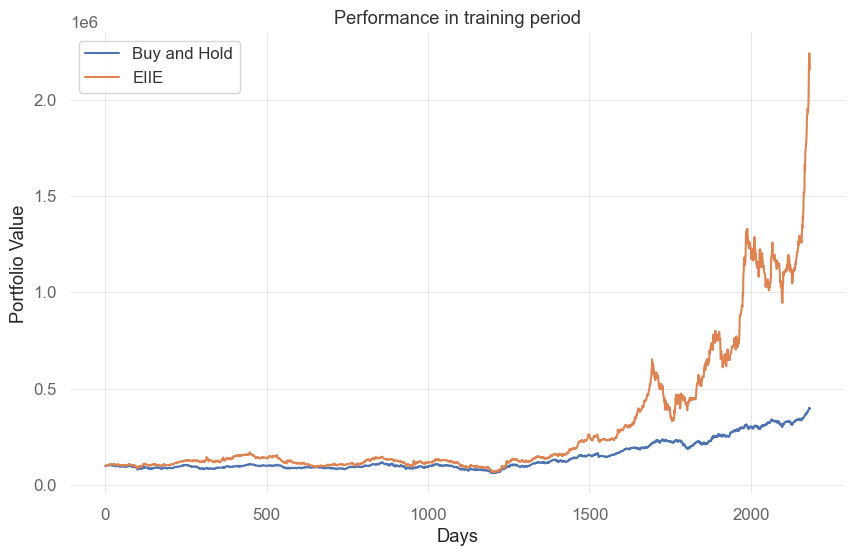

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

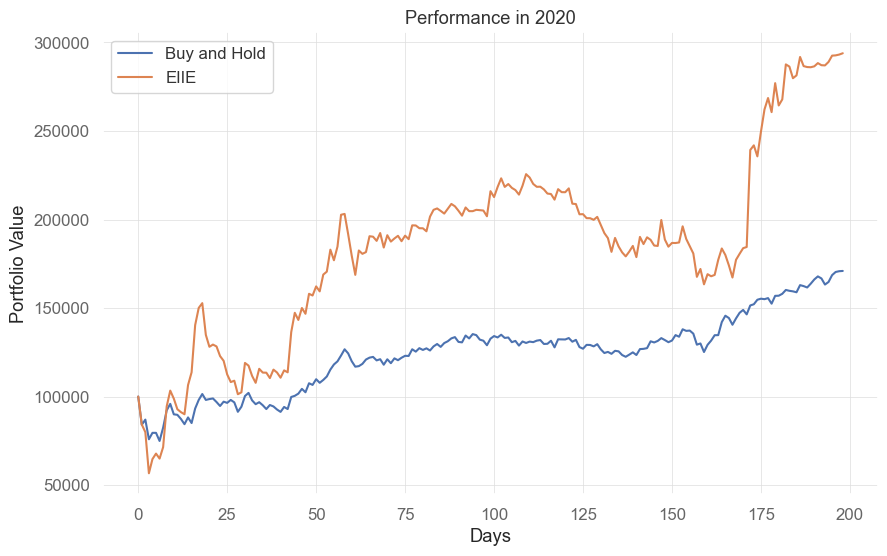

In [30]:
plt.plot(UBAH_results["2020"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2020"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2020")
plt.legend()

plt.show()

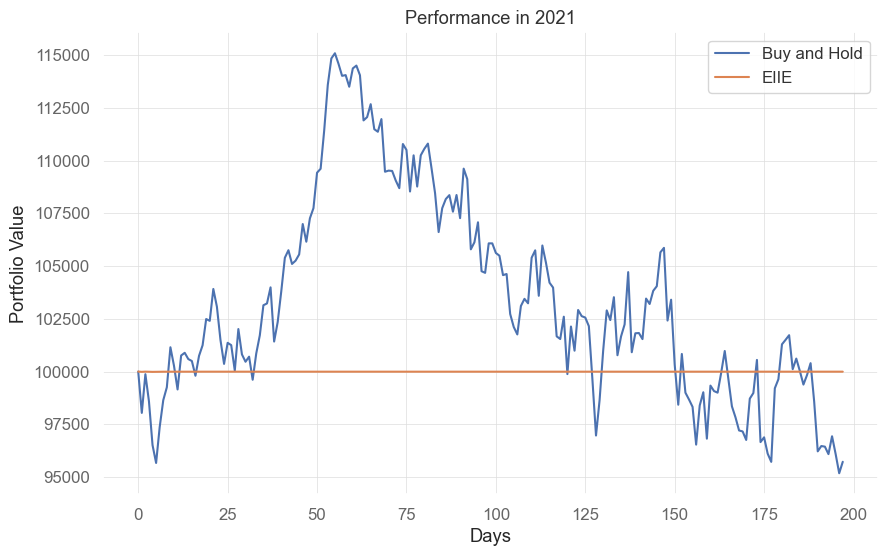

In [31]:
plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

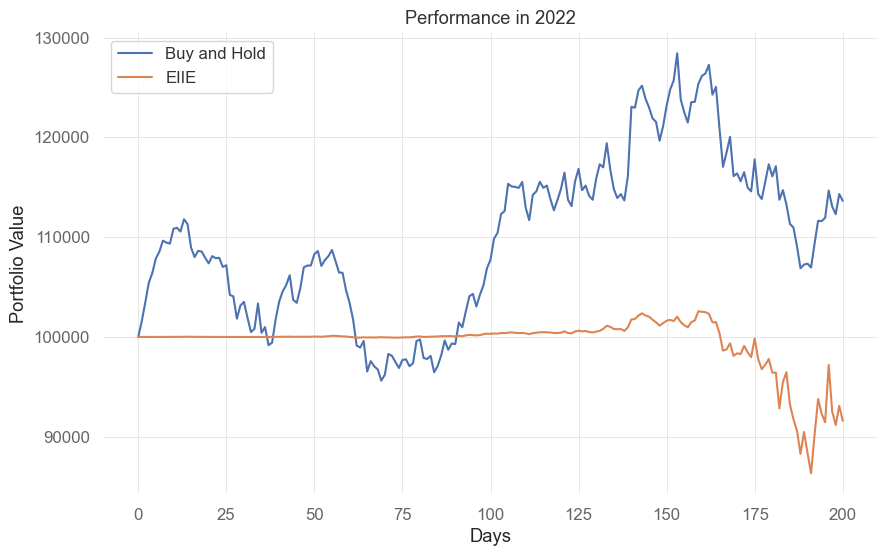

In [32]:
plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

We can see that the agent is able to learn a good policy but its performance is worse the more the test period advances into the future. To get a better performance in 2022, for example, the agent should probably be trained again using more recent data.